# Séries Temporais Gradiente Boosting Regressor

## Importar bibliotecas

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import RegressorChain

## Conectar com Google Drive

In [ ]:
# Conectar com o Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

## Funções

### Cálculo de métricas de previsão

In [2]:
# Métricas de acuidade de previsão
def metricas(previsto, observado):
    erro = previsto - observado                   # erro
    me = np.mean(erro)                            # ME
    mse = np.square(erro).mean()                  # MSE
    rmse = np.sqrt(mse)                           # RMSE
    mae = np.abs(erro).mean()                     # MAE
    mpe = (erro / observado).mean()               # MPE
    mape = np.abs(erro / observado).mean()        # MAPE
    mins = np.amin(np.hstack([previsto[:,None],
                              observado[:,None]]), axis=1)
    maxs = np.amax(np.hstack([previsto[:,None],
                              observado[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)               # MINMAX
    return({'ME':me, 'MSE':mse, 'RMSE':rmse,
            'MAE': mae, 'MPE': mpe, 'MAPE':mape,
            'MIN-MAX':minmax})

### Construção do dataframe treino-teste
#### Contém sequência de n observações e n previsões
São incluídas as seguintes colunas
* X_0 - série original
* X_1 - série defasada de uma posição
* X_2 - série defasada de duas posições
* ...
* X_n-1 - série defasada de n-1 posições
* Y_0 - próximo valor observado após sequência de n observações
* Y_1 - próximo valor defasado de uma posição
* Y_2 - próximo valor defasado de duas posiçções
* ...
* Y_n-1 - série defasada de n-1 posições

In [3]:
def seq_n_obs_n_prev(n: int, serie_original: pd.DataFrame) -> pd.DataFrame:

    df = serie_original.copy()
    # Renomear a coluna 0 para X_0
    df['X_0'] = df.iloc[:, 0]
    df.drop(df.columns[0], axis = 1, inplace=True)

    # Criar as demais colunas defasadas de 1
    i = 1
    while i < n:
        df[f'X_{i}'] = df['X_0'].shift(-i)
        i = i + 1

    j = 0
    while j < n:
        df[f'Y_{j}'] = df['X_0'].shift(-n-j)
        j = j + 1

    # Remover colunas que não possuam valores NaN
    df = df.dropna(axis=0)

    return df

### Selecionar parâmetros para o modelo
Para range de valores de n e range de tamanhos de teste
* Cria série com N colunas de treino com N colunas de previsão
* Cria dados de treino e de teste
* Cria e ajusta modelo
* Calcula previsões
* Calcula métricas
* Salva melhores parâmetros

In [4]:
def selecionar_parametros(serie_original: pd.DataFrame):

    tam_serie = serie_original.shape[0]
    melhor_MAPE = 100
    max_n = int(0.1*tam_serie)
    melhor_n = 0

    for n in range(2, max_n):
        # Cria série N colunas de ttreino N colunas de previsão
        serie_N_N = seq_n_obs_n_prev(n, serie_original)
        max_teste = math.floor(tam_serie/n)

        for tam_teste in range (2, max_teste):
            # Cria dados de treino e de teste
            tam_treino = tam_serie - tam_teste
            X_cols = [col for col in serie_N_N.columns if col.startswith('X')]
            Y_cols = [col for col in serie_N_N.columns if col.startswith('Y')]
            X_treino = serie_N_N[X_cols][:tam_treino].values
            Y_treino = serie_N_N[Y_cols][:tam_treino].values
            X_teste = serie_N_N[X_cols][-tam_teste:].values
            Y_teste = serie_N_N[Y_cols][-tam_teste:].values

            # Cria MODELO
            modelo = GradientBoostingRegressor(random_state=42)
            MODELO = RegressorChain(modelo)
            # Ajusta modelo GB
            MODELO.fit(X_treino, Y_treino)
            # Faz previsões com MODELO
            Y_prev = MODELO.predict(X_teste)

            # Calcula métricas
            metricas_ = metricas(Y_prev.reshape(1, -1), Y_teste.reshape(1, -1))

            # Salva parâmetros
            if (metricas_['MAPE'] < melhor_MAPE):
                melhor_MAPE = metricas_['MAPE']
                melhor_n = n
                melhor_tamanho_teste = tam_teste

    return [melhor_n, melhor_tamanho_teste, melhor_MAPE]

# Série requisições diárias aos servidores

### Leitura de dados

In [5]:
# ler dados sintéticos com tendência, sazonalidade e ruído
serie_requisicoes_dia = pd.read_csv(
    '/content/servidores_requisicoes_dia.csv', index_col=0, parse_dates=True)

serie_requisicoes_dia.head(3)

,WEB,BD,APLIC
Data,,,
2006-01-01,1069.184,NaN,NaN
2006-01-02,1380.521,NaN,NaN
2006-01-03,1442.533,NaN,NaN


# EXEMPLO: Série de requisições mensais ao servidor WEB

In [6]:
# Seleciona coluna WEB e reformata para requisições mensais (soma)
mensal = serie_requisicoes_dia['WEB'].resample('M').sum()
serie_WEB = pd.DataFrame(mensal.values, mensal.index, columns=['Valor'])
serie_WEB.head(5)

<ipython-input-6-4218340ec5d9>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  mensal = serie_requisicoes_dia['WEB'].resample('M').sum()


,Valor
Data,
2006-01-31,45304.704
2006-02-28,41078.993
2006-03-31,43978.124
2006-04-30,38251.767
2006-05-31,38858.143


## Visualizar requisições mensais ao servidor WEB

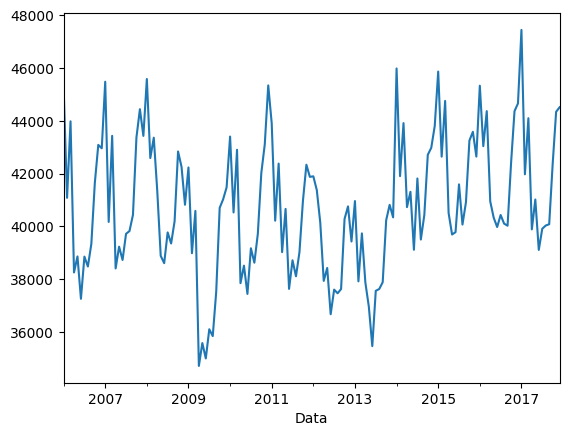

In [7]:
# Plotar WEB
serie_WEB['Valor'].plot();

# Modelo - Série WEB Gradiente Boosting

## Preparação de Dados

### Selecionar parâmetros para o modelo
### PODE DEMORAR BASTANTE!!!

In [8]:
[melhor_n_WEB, melhor_tamanho_teste_WEB, melhor_MAPE_WEB] = selecionar_parametros(serie_WEB)

### Imprimir parâmetros do modelo

In [9]:
print(f'Melhor n: {melhor_n_WEB}')
print(f'Melhor tamanho teste: {melhor_tamanho_teste_WEB}')
print(f'Melhor MAPE: {melhor_MAPE_WEB}')

Melhor n: 7
Melhor tamanho teste: 2
Melhor MAPE: 0.004926175619093124


### Construir dataframe serie_WEB_GB

In [10]:
# Criar dataframe com n sequências de observações
serie_WEB_GB = seq_n_obs_n_prev(melhor_n_WEB, serie_WEB)

## Construção dos dados e dataframes de treinamento e teste

### Preparação para construção dos dados e dataframes de treinamento e teste
* Definir tamanho dos daos de teste e treinamento
* Montar string com nome das colunas X_i para filtrar as colunas no dataframe serie_WEB_GB
* Montar string com nome das colunas Y_i para filtrar as colunas no dataframe serie__WEB_GB

In [11]:
# Calcular tamanhos das séries de treinamento e teste
# A série original é dividida em dados de treinamento e teste
tam_teste_WEB_GB = melhor_tamanho_teste_WEB
tam_treino_WEB_GB = serie_WEB_GB.shape[0] - tam_teste_WEB_GB
print(f'Tamanho do conjunto de teste: {tam_teste_WEB_GB}')
print(f'Tamanho do conjunto de treino: {tam_treino_WEB_GB}')


# Montar string com nome das colunas X_i para filtrar as colunas no dataframe serie_GB
X_cols = [col for col in serie_WEB_GB.columns if col.startswith('X')]


# Montar string com nome das colunas Y_i para filtrar as colunas no dataframe serie_GB
Y_cols = [col for col in serie_WEB_GB.columns if col.startswith('Y')]

Tamanho do conjunto de teste: 2
Tamanho do conjunto de treino: 129


### Construir dados de treinamento
* Costruir arrays X_treino_WEB_GB e Y_treino_WEB_GB
* Construir dataframe serie_treino_WEB_GB_vusualizacao

#### Construir arrays X_treino_WEB_GB e Y_treino_WEB_GB

In [12]:
# Construir X_treino_GB e Y_treino_GB
X_treino_WEB_GB = serie_WEB_GB[X_cols][:tam_treino_WEB_GB].values
Y_treino_WEB_GB = serie_WEB_GB[Y_cols][:tam_treino_WEB_GB].values


# Imprimir X_treino e Y_treino para conferência

# A quantidade de linhas em X_treino e Y_treino deve ser
# igual ao tamanho do conjunto de treino

# A quantidade de colunas em X_treino e Y_treino deve ser
# a quantidade de seqência de dados usados para treino

print(f'Tamanho do conjunto de treino: {tam_treino_WEB_GB}')
print(f'Quantidade de sequência de dados usados para treino: {melhor_n_WEB}')
print(f'Formato dos dados X_treino: {X_treino_WEB_GB.shape}')
print(f'Formato dos dados Y_treino: {Y_treino_WEB_GB.shape}')

Tamanho do conjunto de treino: 129
Quantidade de sequência de dados usados para treino: 7
Formato dos dados X_treino: (129, 7)
Formato dos dados Y_treino: (129, 7)


### Construir dados de teste

#### Construir arrays X_teste_WEB_GB e Y_teste_WEB_GB

In [13]:
# Construir arrays X_teste_WEB_GB e Y_teste__WEB_GB
X_teste_WEB_GB = serie_WEB_GB[X_cols][-tam_teste_WEB_GB:].values
Y_teste_WEB_GB = serie_WEB_GB[Y_cols][-tam_teste_WEB_GB:].values

print(f'Tamanho do conjunto de teste: {tam_teste_WEB_GB}')
print(f'Quantidade de sequência de dados usados para teste: {melhor_n_WEB}')
print(f'Formato dos dados X_teste: {X_teste_WEB_GB.shape}')
print(f'Formato dos dados Y_teste: {Y_teste_WEB_GB.shape}')

Tamanho do conjunto de teste: 2
Quantidade de sequência de dados usados para teste: 7
Formato dos dados X_teste: (2, 7)
Formato dos dados Y_teste: (2, 7)


## Modelo -  WEB GB
### Gradiente boosting regressor para série WEB
* As previsões são realizadas pelo regressor (GradientBoostingRegressor)
* As previsões são organizadas em múltiplas previsões pelo método RegressorChain

Os formatos são impressos para conferência dos tipos de dados.

In [14]:
# Criar modelo_WEB_GB
modelo_GB = GradientBoostingRegressor(random_state=42)
modelo_WEB_GB = RegressorChain(modelo_GB)

# Ajustar modelo GB
modelo_WEB_GB.fit(X_treino_WEB_GB, Y_treino_WEB_GB)

# Fazer previsões com modelo GB
Y_prev_WEB_GB = modelo_WEB_GB.predict(X_teste_WEB_GB)

## Construir dataframe serie_previsto_WEB_GB
* Esse dataframe é usado para salvar os dados de teste e previsão para plotagem
* Contém as colunas: Y_observado e Y_prev
* Esse dataframe é utilizado para plotagem das previsões

In [15]:
# Construir dataframe serie_previsto_WEB_GB
# Contém as colunas Y_observado e Y_prev
# Cada uma contém o tamanho do conjnto de teste multiplicado por n
# Selecionados até a penúltima coluna do dataframe original #######
serie_previsto_WEB_GB = serie_WEB[-(tam_teste_WEB_GB*melhor_n_WEB + 1):-1]
serie_previsto_WEB_GB = serie_previsto_WEB_GB.copy()


# Incluir a coluna Y_observado
serie_previsto_WEB_GB['Y_observado'] = serie_previsto_WEB_GB['Valor']


# Incluir as colunas Y_prev
serie_previsto_WEB_GB['Y_prev'] = Y_prev_WEB_GB.reshape(-1,1)

### Plotar gráfico de previsões

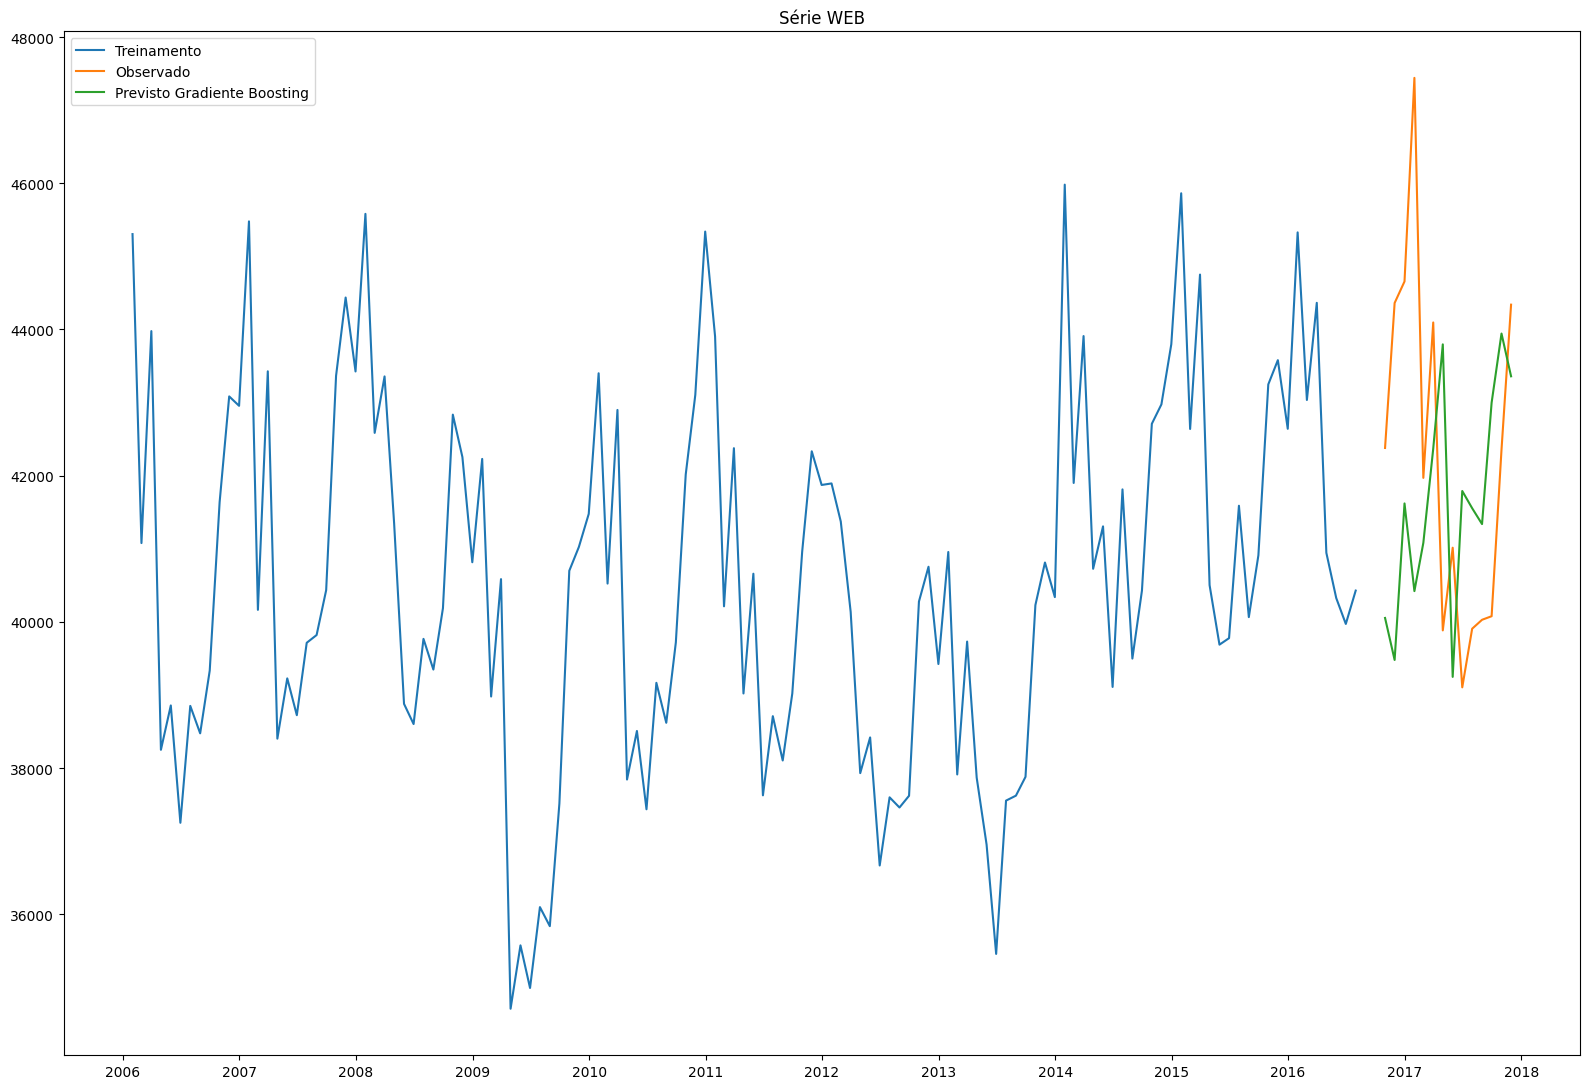

In [16]:
# Plot
fig, ax = plt.subplots(figsize=(16, 11))
ax.plot(serie_WEB[:tam_treino_WEB_GB-2]['Valor'], label='Treinamento')
ax.plot(serie_previsto_WEB_GB['Y_observado'], label='Observado')
ax.plot(serie_previsto_WEB_GB['Y_prev'], label='Previsto Gradiente Boosting')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend(loc='upper left', fontsize=10)
ax.set_title('Série WEB');
plt.tight_layout()

## Modelo WEB GB - Desempenho

### Parâmetros

In [17]:
print(f'n =  {melhor_n_WEB}')
print(f'tamanho do conjunto de teste =  {melhor_tamanho_teste_WEB}')

n =  7
tamanho do conjunto de teste =  2


### Calcular e imprimir métricas do modelo_WEB_GB

In [18]:
# Calcular array com métricas para modelo_WEB_GB
metricas_WEB_GB = metricas(Y_prev_WEB_GB.reshape(1, -1), Y_teste_WEB_GB.reshape(1, -1))

# Imprimir métricas de previsão
METRICAS = []
VALORES_WEB_GB = []
print('Metricas Modelo WEB GB')
for metrica in metricas_WEB_GB:
    print(f'{metrica} = {metricas_WEB_GB[metrica]}')
    METRICAS.append(metrica)
    VALORES_WEB_GB.append(metricas_WEB_GB[metrica])

Metricas Modelo WEB GB
ME = 421.7371482152391
MSE = 1059665.9549360336
RMSE = 1029.4007746917785
MAE = 857.4755127582149
MPE = 0.010918418235607538
MAPE = 0.020982266595026774
MIN-MAX = 0.02046146175799246


### Salvar méticas para comparação

In [19]:
dfMetricas = pd.read_csv('/content/Métricas_Previsão.csv', index_col=0)
dfMetricas = dfMetricas.assign(WEB_GB=VALORES_WEB_GB)
print(dfMetricas)
dfMetricas.to_csv('/content/Métricas_Previsão.csv')

         ST_Baseline  WEB_Baseline   BD_Baseline  ST_AUTOARIMA  BD_AUTOARIMA  \
ME         -0.175799 -7.450912e+01 -3.879495e+02     49.857660 -1.347929e+03   
MSE       172.614151  4.322896e+06  6.146474e+06   7831.582677  5.482356e+06   
RMSE       13.138270  2.079158e+03  2.479208e+03     88.496230  2.341443e+03   
MAE        10.363013  1.653027e+03  1.862858e+03     71.980169  1.694711e+03   
MPE         0.004776 -5.410408e-04  5.406480e-03      0.014344 -1.300227e-01   
MAPE        0.086862  3.921937e-02  2.499672e-01      0.020229  2.059837e-01   
MIN-MAX     0.081098  3.780842e-02  2.116844e-01      0.019672  1.985067e-01   

         WEB_AUTOARIMA          ST_GB        WEB_GB         BD_GB      ST_RN  \
ME       -4.533259e+03    -255.863571  4.217371e+02 -4.634744e+03  -0.994816   
MSE       2.178596e+07  367645.818074  1.059666e+06  2.692134e+07  58.959614   
RMSE      4.667544e+03     606.338039  1.029401e+03  5.188578e+03   7.678516   
MAE       4.533259e+03     466.513514  

# Comparar desempenho de modelos
* Série: Sintética e WEB
* Modelos: Baseline, AUTOARIMA e GB

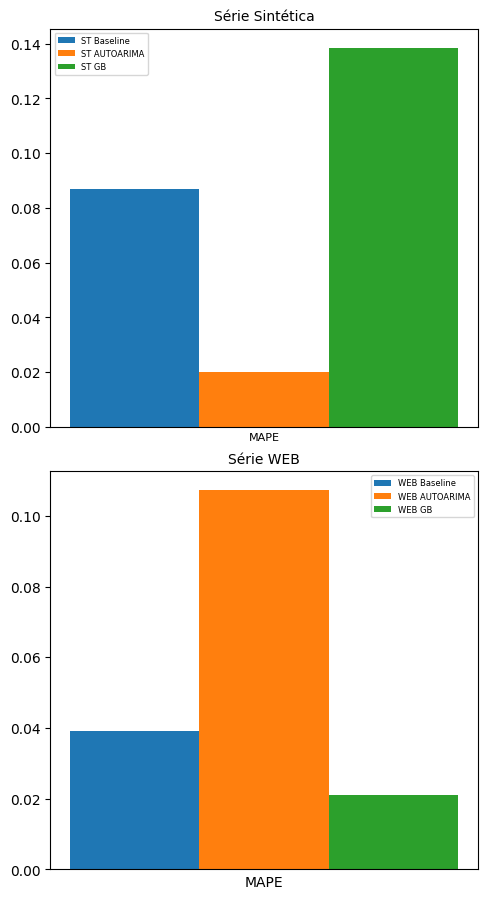

In [20]:
# Preparar dados
MAPE_ST_Baseline = dfMetricas['ST_Baseline'].loc['MAPE']
MAPE_ST_AUTOARIMA = dfMetricas['ST_AUTOARIMA'].loc['MAPE']
MAPE_ST_GB = dfMetricas['ST_GB'].loc['MAPE']

MAPE_WEB_Baseline = dfMetricas['WEB_Baseline'].loc['MAPE']
MAPE_WEB_AUTOARIMA = dfMetricas['WEB_AUTOARIMA'].loc['MAPE']
MAPE_WEB_GB = dfMetricas['WEB_GB'].loc['MAPE']

# Plotar
fig, axes = plt.subplots(2, 1, figsize=(5, 9))
fig.tight_layout()

# Série sintética
axes[0].set_title('Série Sintética', fontsize=10)
axes[0].bar(-0.4, MAPE_ST_Baseline, 0.4, label = 'ST Baseline')
axes[0].bar(0, MAPE_ST_AUTOARIMA, 0.4, label = 'ST AUTOARIMA')
axes[0].bar(0.4, MAPE_ST_GB, 0.4, label = 'ST GB')
axes[0].set_xlabel('MAPE', fontsize=8)
axes[0].set_xticks([])
axes[0].legend(fontsize=6);

# Série WEB
axes[1].set_title('Série WEB', fontsize=10)
axes[1].bar(-0.4, MAPE_WEB_Baseline, 0.4, label = 'WEB Baseline')
axes[1].bar(0, MAPE_WEB_AUTOARIMA, 0.4, label = 'WEB AUTOARIMA')
axes[1].bar(0.4, MAPE_WEB_GB, 0.4, label = 'WEB GB')
axes[1].set_xlabel('MAPE', fontsize=10)
axes[1].set_xticks([])
axes[1].legend(fontsize=6);

# FORMATIVA: Série de requisições mensais ao servidor BD

In [21]:
# Seleciona coluna BD e reformata para requisições mensais (soma)
serie_requisicoes_BD_mes = serie_requisicoes_dia['BD'].resample('M').sum()

# Selecionar dados a partir de Janeiro de 2010
mensal = pd.Series(serie_requisicoes_BD_mes.loc['2010-01':'2017-12'], copy=True)

# Formatação com idex = data e coluna = Valor
serie_BD = pd.DataFrame(mensal.values, mensal.index, columns=['Valor'])
serie_BD.head(10)

<ipython-input-21-e241eada6453>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  serie_requisicoes_BD_mes = serie_requisicoes_dia['BD'].resample('M').sum()


,Valor
Data,
2010-01-31,3148.914
2010-02-28,3398.549
2010-03-31,4295.821
2010-04-30,2902.002
2010-05-31,2502.340
2010-06-30,1738.655
2010-07-31,1581.406
2010-08-31,2390.503
2010-09-30,2845.981


## Visualizar requisições mensais ao servidor BD

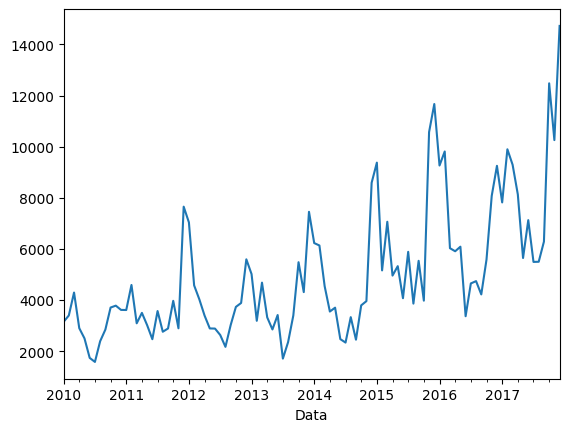

In [22]:
# Plotar BD
serie_BD['Valor'].plot();

# Modelo - Série BD Gradiente Boosting

## Preparação de Dados

### Selecionar parâmetros para o modelo
### PODE DEMORAR BASTANTE !!!

In [23]:
[melhor_n_BD, melhor_tamanho_teste_BD, melhor_MAPE_BD] = selecionar_parametros(serie_BD)

### Imprimir parâmetros selecionados

In [24]:
print(f'Melhor n: {melhor_n_BD}')
print(f'Melhor tamanho teste: {melhor_tamanho_teste_BD}')
print(f'Melhor MAPE: {melhor_MAPE_BD}')

Melhor n: 2
Melhor tamanho teste: 2
Melhor MAPE: 0.022957059544726505


### Construir dataframe serie_BD_GB

In [25]:
# Criar dataframe com n sequências de observações
serie_BD_GB = seq_n_obs_n_prev(melhor_n_BD, serie_BD)

### Construir dados e dataframes de treinamento e teste

In [26]:

# Calcular tamanhos das séries de treinamento e teste
# A série original é dividida em dados de treinamento e teste
tam_teste_BD_GB = melhor_tamanho_teste_BD
tam_treino_BD_GB = serie_BD_GB.shape[0] - tam_teste_BD_GB
print(f'Tamanho do conjunto de teste: {tam_teste_BD_GB}')
print(f'Tamanho do conjunto de treino: {tam_treino_BD_GB}')

# Montar string com nome das colunas X_i para filtrar as colunas no dataframe serie_GB
X_cols = [col for col in serie_BD_GB.columns if col.startswith('X')]


# Montar string com nome das colunas Y_i para filtrar as colunas no dataframe serie_GB
Y_cols = [col for col in serie_BD_GB.columns if col.startswith('Y')]

Tamanho do conjunto de teste: 2
Tamanho do conjunto de treino: 91


### Construir dados de treinamento

In [27]:
# Construir X_treino_BD_GB e Y_treino_BD_GB
X_treino_BD_GB = serie_BD_GB[X_cols][:tam_treino_BD_GB].values
Y_treino_BD_GB = serie_BD_GB[Y_cols][:tam_treino_BD_GB].values

# Imprimir X_treino e Y_treino para conferência

# A quantidade de linhas em X_treino e Y_treino deve ser
# igual ao tamanho do conjunto de treino

# A quantidade de colunas em X_treino e Y_treino deve ser
# a quantidade de seqência de dados usados para treino
print(f'Tamanho do conjunto de treino: {tam_treino_BD_GB}')
print(f'Quantidade de sequência de dados usados para treino: {melhor_n_BD}')
print(f'Formato dos dados X_treino: {X_treino_BD_GB.shape}')
print(f'Formato dos dados Y_treino: {Y_treino_BD_GB.shape}')

Tamanho do conjunto de treino: 91
Quantidade de sequência de dados usados para treino: 2
Formato dos dados X_treino: (91, 2)
Formato dos dados Y_treino: (91, 2)


### Construir dados de teste

In [28]:

# Construir arrays X_teste_BD_GB e Y_teste__BD_GB

X_teste_BD_GB = serie_BD_GB[X_cols][-tam_teste_BD_GB:].values
Y_teste_BD_GB = serie_BD_GB[Y_cols][-tam_teste_BD_GB:].values

# Impressão de formatos e tamanhos para conferencia
print(f'Tamanho do conjunto de teste: {tam_teste_BD_GB}')
print(f'Quantidade de sequência de dados usados para teste: {melhor_n_BD}')
print(f'Formato dos dados X_teste: {X_teste_BD_GB.shape}')
print(f'Formato dos dados Y_teste: {Y_teste_BD_GB.shape}')

Tamanho do conjunto de teste: 2
Quantidade de sequência de dados usados para teste: 2
Formato dos dados X_teste: (2, 2)
Formato dos dados Y_teste: (2, 2)


## Modelo -  BD GB
### Gradiente boosting regressor para série BD

In [29]:
# Criar modelo BD_GB
modelo_BD_GB = GradientBoostingRegressor(random_state=42)

# Ajustar modelo BD_GB
MODELO_BD_GB = RegressorChain(modelo_BD_GB)

# Ajustar modelo BD_GB
MODELO_BD_GB.fit(X_treino_BD_GB, Y_treino_BD_GB)

# Fazer previsões com modelo BD_GB
Y_prev_BD_GB = MODELO_BD_GB.predict(X_teste_BD_GB)


## Construir dataframe serie_previsto_BD_GB

In [30]:
# Construir dataframe serie_previsto_BD_GB
serie_previsto_BD_GB = serie_BD[-(tam_teste_BD_GB*melhor_n_BD + 1):-1]
serie_previsto_BD_GB = serie_previsto_BD_GB.copy()

# Incluir a coluna Y_observado
serie_previsto_BD_GB['Y_observado'] = serie_previsto_BD_GB['Valor']


# Incluir as colunas Y_prev
serie_previsto_BD_GB['Y_prev'] = Y_prev_BD_GB.reshape(-1,1)

### Plotar gráfico de previsões

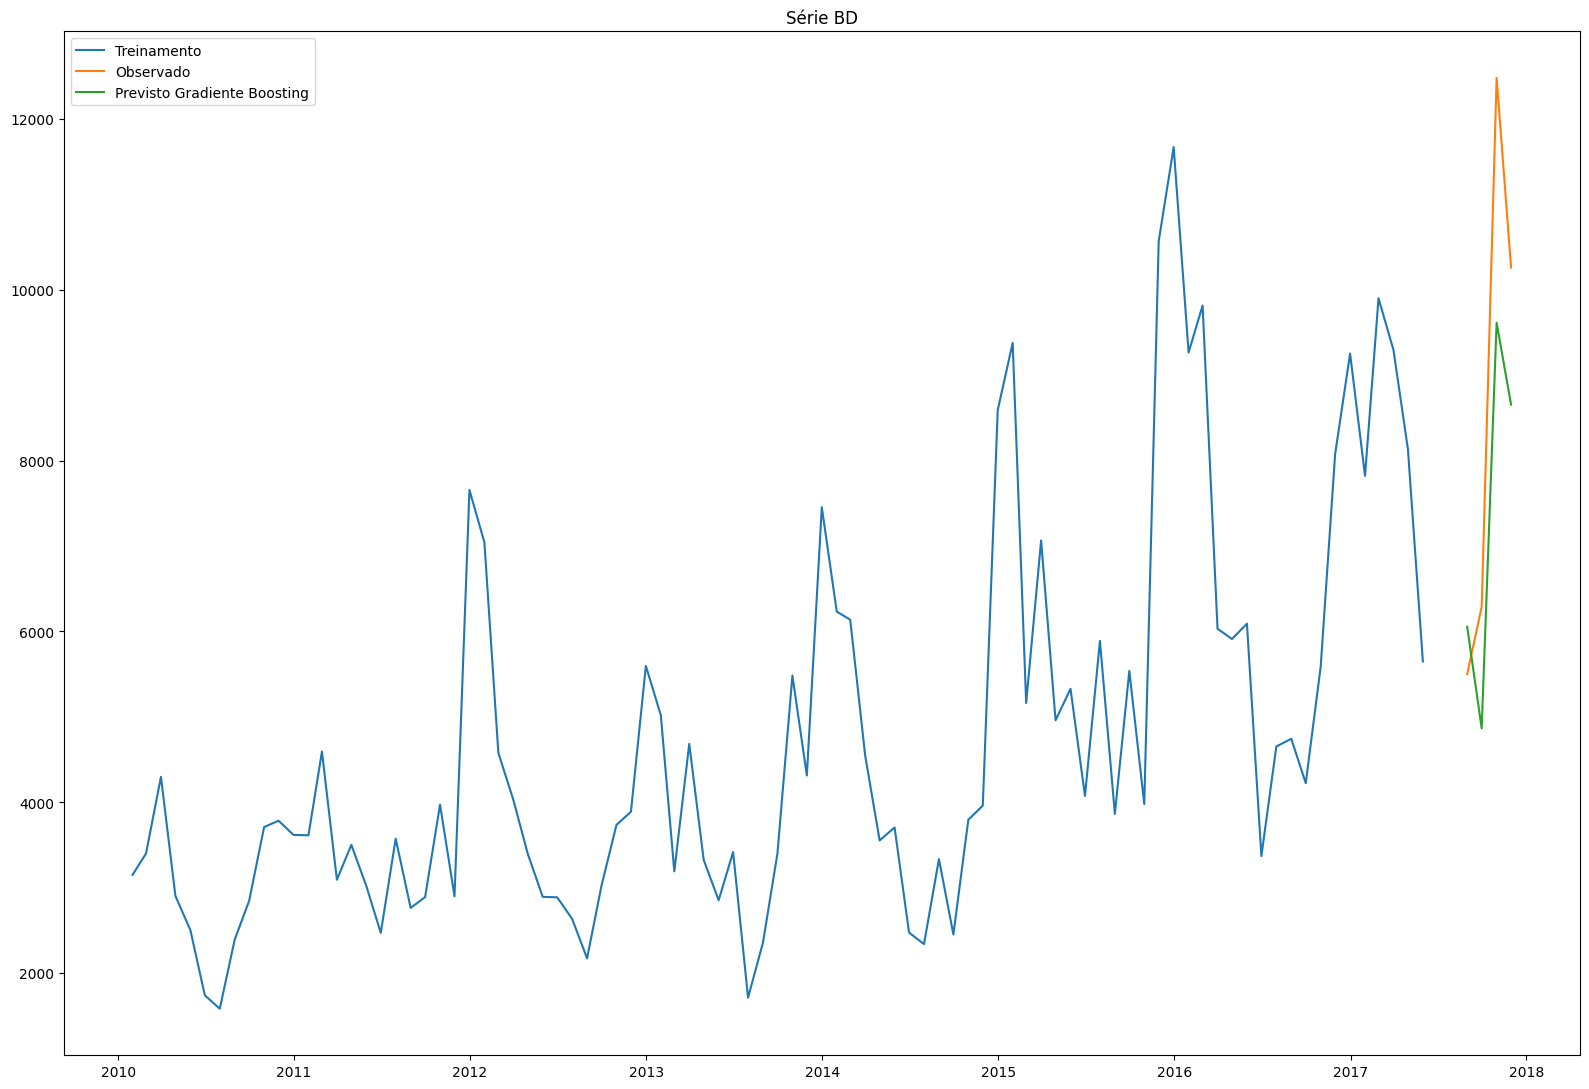

In [31]:
# Plot
fig, ax = plt.subplots(figsize=(16, 11))
ax.plot(serie_BD[:tam_treino_BD_GB-2]['Valor'], label='Treinamento')
ax.plot(serie_previsto_BD_GB['Y_observado'], label='Observado')
ax.plot(serie_previsto_BD_GB['Y_prev'], label='Previsto Gradiente Boosting')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend(loc='upper left', fontsize=10)
ax.set_title('Série BD');
plt.tight_layout()

## Modelo BD_GB - Desempenho

### Parâmetros

In [32]:
print(f'n =  {melhor_n_BD}')
print(f'tamanho do conjunto de teste =  {melhor_tamanho_teste_BD}')

n =  2
tamanho do conjunto de teste =  2


### Calcular e imprimir métricas do modelo BD_GB

In [33]:
# Calcular array com métricas para modelo_BD_GB
metricas_BD_GB = metricas(Y_prev_BD_GB.reshape(1, -1), Y_teste_BD_GB.reshape(1, -1))

# Imprimir métricas de previsão
METRICAS = []
VALORES_BD_GB = []
print('Metricas Modelo BD_GB')
for metrica in metricas_BD_GB:
    print(f'{metrica} = {metricas_BD_GB[metrica]}')
    METRICAS.append(metrica)
    VALORES_BD_GB.append(metricas_BD_GB[metrica])

Metricas Modelo BD_GB
ME = -4634.7437980864615
MSE = 26921344.74793634
RMSE = 5188.578297369747
MAE = 4634.7437980864615
MPE = -0.3790255539271398
MAPE = 0.3790255539271398
MIN-MAX = 0.37902555392713977


### Salvar méticas para comparação

In [34]:
dfMetricas = pd.read_csv('/content/Métricas_Previsão.csv', index_col=0)
dfMetricas = dfMetricas.assign(BD_GB=VALORES_BD_GB)
print(dfMetricas)
dfMetricas.to_csv('/content/Métricas_Previsão.csv')

         ST_Baseline  WEB_Baseline   BD_Baseline  ST_AUTOARIMA  BD_AUTOARIMA  \
ME         -0.175799 -7.450912e+01 -3.879495e+02     49.857660 -1.347929e+03   
MSE       172.614151  4.322896e+06  6.146474e+06   7831.582677  5.482356e+06   
RMSE       13.138270  2.079158e+03  2.479208e+03     88.496230  2.341443e+03   
MAE        10.363013  1.653027e+03  1.862858e+03     71.980169  1.694711e+03   
MPE         0.004776 -5.410408e-04  5.406480e-03      0.014344 -1.300227e-01   
MAPE        0.086862  3.921937e-02  2.499672e-01      0.020229  2.059837e-01   
MIN-MAX     0.081098  3.780842e-02  2.116844e-01      0.019672  1.985067e-01   

         WEB_AUTOARIMA          ST_GB        WEB_GB         BD_GB      ST_RN  \
ME       -4.533259e+03    -255.863571  4.217371e+02 -4.634744e+03  -0.994816   
MSE       2.178596e+07  367645.818074  1.059666e+06  2.692134e+07  58.959614   
RMSE      4.667544e+03     606.338039  1.029401e+03  5.188578e+03   7.678516   
MAE       4.533259e+03     466.513514  

# Comparar desempenho de modelos
* Série: Sintética, WEB e BD
* Modelos: Baseline, AUTOARIMA e GB

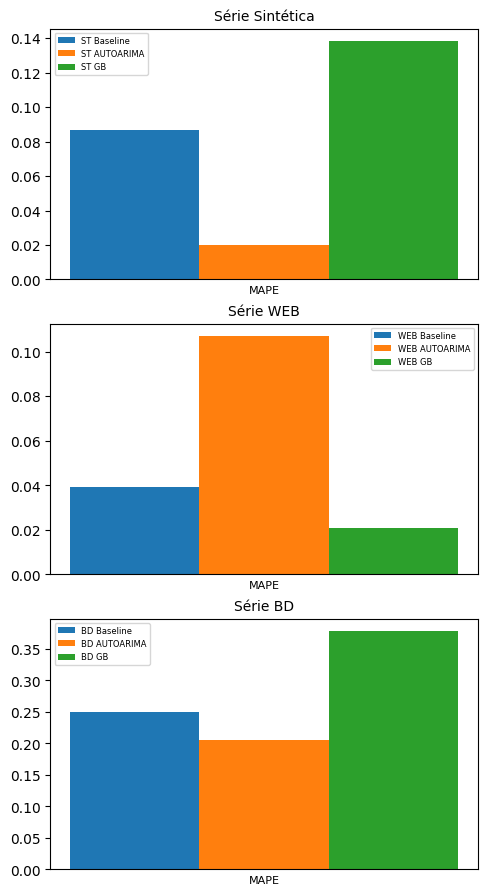

In [35]:
# Preparar dados
MAPE_ST_Baseline = dfMetricas['ST_Baseline'].loc['MAPE']
MAPE_ST_AUTOARIMA = dfMetricas['ST_AUTOARIMA'].loc['MAPE']
MAPE_ST_GB = dfMetricas['ST_GB'].loc['MAPE']

MAPE_WEB_Baseline = dfMetricas['WEB_Baseline'].loc['MAPE']
MAPE_WEB_AUTOARIMA = dfMetricas['WEB_AUTOARIMA'].loc['MAPE']
MAPE_WEB_GB = dfMetricas['WEB_GB'].loc['MAPE']

# PREPRAR DADOS SÉRIE BD
MAPE_BD_Baseline = dfMetricas['BD_Baseline'].loc['MAPE']
MAPE_BD_AUTOARIMA = dfMetricas['BD_AUTOARIMA'].loc['MAPE']
MAPE_BD_GB = dfMetricas['BD_GB'].loc['MAPE']



# Plotar
fig, axes = plt.subplots(3, 1, figsize=(5, 9))
fig.tight_layout()

# Série sintética
axes[0].set_title('Série Sintética', fontsize=10)
axes[0].bar(-0.4, MAPE_ST_Baseline, 0.4, label = 'ST Baseline')
axes[0].bar(0, MAPE_ST_AUTOARIMA, 0.4, label = 'ST AUTOARIMA')
axes[0].bar(0.4, MAPE_ST_GB, 0.4, label = 'ST GB')
axes[0].set_xlabel('MAPE', fontsize=8)
axes[0].set_xticks([])
axes[0].legend(fontsize=6);

# Série WEB
axes[1].set_title('Série WEB', fontsize=10)
axes[1].bar(-0.4, MAPE_WEB_Baseline, 0.4, label = 'WEB Baseline')
axes[1].bar(0, MAPE_WEB_AUTOARIMA, 0.4, label = 'WEB AUTOARIMA')
axes[1].bar(0.4, MAPE_WEB_GB, 0.4, label = 'WEB GB')
axes[1].set_xlabel('MAPE', fontsize=8)
axes[1].set_xticks([])
axes[1].legend(fontsize=6);

# PLOTAR SÉRIE BD

axes[2].set_title('Série BD', fontsize=10)
axes[2].bar(-0.4, MAPE_BD_Baseline, 0.4, label = 'BD Baseline')
axes[2].bar(0, MAPE_BD_AUTOARIMA, 0.4, label = 'BD AUTOARIMA')
axes[2].bar(0.4, MAPE_BD_GB, 0.4, label = 'BD GB')
axes[2].set_xlabel('MAPE', fontsize=8)
axes[2].set_xticks([])
axes[2].legend(fontsize=6);
